In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
features_folder = Path("D:/COMPUTER SCIENCE/cHEAL/Project-1/harshitha/Data")
label_path = Path("D:/COMPUTER SCIENCE/cHEAL/Project-1/harshitha/labels/expanded_file.csv")
results_path = Path("D:/COMPUTER SCIENCE/cHEAL/Project-1/harshitha/Results")
results_path.mkdir(parents=True, exist_ok=True)
model_path = Path("D:/COMPUTER SCIENCE/cHEAL/Project-1/harshitha/models")
model_path.mkdir(parents=True, exist_ok=True)

In [4]:
label_df = pd.read_csv(label_path)

In [5]:
csv_files = list(features_folder.glob("Subject_*_T4_Meaningful_Text_fixations.csv"))
subject_ids = [int(f.stem.split('_')[1]) for f in csv_files]

In [6]:
train_ids, test_ids = train_test_split(subject_ids, test_size=0.2, random_state=42)

In [7]:
def extract_features(subject_id):
    file = features_folder / f"Subject_{subject_id}_T4_Meaningful_Text_fixations.csv"
    if not file.exists(): return None
    df = pd.read_csv(file)
    if df.empty: return None
    return pd.Series({
        'subject_id': subject_id,
        'fixation_count': len(df),
        'mean_duration': df['duration_ms'].mean(),
        'std_duration': df['duration_ms'].std(),
        'mean_fix_x': df['fix_x'].mean(),
        'mean_fix_y': df['fix_y'].mean(),
        'mean_saccade_length': np.mean(np.sqrt(np.diff(df['fix_x'])**2 + np.diff(df['fix_y'])**2)) if len(df) > 1 else 0
    })

In [8]:
train_data, test_data = [], []

for sid in train_ids:
    feats = extract_features(sid)
    if feats is not None:
        feats['class_id'] = label_df.loc[label_df['subject_id'] == sid, 'class_id'].values[0]
        train_data.append(feats)

for sid in test_ids:
    feats = extract_features(sid)
    if feats is not None:
        feats['class_id'] = label_df.loc[label_df['subject_id'] == sid, 'class_id'].values[0]
        test_data.append(feats)

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [9]:
X_train = train_df.drop(columns=['subject_id', 'class_id'])
y_train = train_df['class_id']
X_test = test_df.drop(columns=['subject_id', 'class_id'])
y_test = test_df['class_id']

In [10]:
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)
print("✅ SVM model trained on 80% of CSV files.")

✅ SVM model trained on 80% of CSV files.


In [11]:
model_file = model_path / "svm_model_csv.pkl"
joblib.dump(svm_model, model_file)
print(f"💾 Model saved as {model_file}")

💾 Model saved as D:\COMPUTER SCIENCE\cHEAL\Project-1\harshitha\models\svm_model_csv.pkl


In [12]:
y_pred = svm_model.predict(X_test)
train_pred = svm_model.predict(X_train)
train_proba = svm_model.predict_proba(X_train)[:, 1]
test_proba = svm_model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'subject_id': test_df['subject_id'].values,
    'actual': y_test.map({0: 'non-dyslexic', 1: 'dyslexic'}).values,
    'predicted': pd.Series(y_pred, index=y_test.index).map({0: 'non-dyslexic', 1: 'dyslexic'}).values
})

print("\n🔍 Ground Truth vs Predicted:\n")
print(results_df.reset_index(drop=True))


🔍 Ground Truth vs Predicted:

    subject_id        actual     predicted
0       1255.0  non-dyslexic  non-dyslexic
1       3258.0  non-dyslexic  non-dyslexic
2       2095.0  non-dyslexic  non-dyslexic
3       3744.0      dyslexic  non-dyslexic
4       1760.0      dyslexic  non-dyslexic
5       3109.0  non-dyslexic  non-dyslexic
6       1377.0  non-dyslexic  non-dyslexic
7       3345.0  non-dyslexic  non-dyslexic
8       1065.0  non-dyslexic  non-dyslexic
9       3626.0      dyslexic  non-dyslexic
10      2913.0      dyslexic      dyslexic
11      3398.0  non-dyslexic  non-dyslexic
12      3929.0      dyslexic      dyslexic
13      2626.0      dyslexic  non-dyslexic
14      1109.0  non-dyslexic  non-dyslexic
15      2019.0  non-dyslexic  non-dyslexic
16      3187.0  non-dyslexic  non-dyslexic
17      1134.0      dyslexic      dyslexic
18      3235.0  non-dyslexic  non-dyslexic
19      2174.0      dyslexic  non-dyslexic
20      2033.0  non-dyslexic  non-dyslexic
21      1591.0      dys

In [13]:
results_df.to_csv(results_path / "svm_predictions_meaningful_test_from_csv_split.csv", index=False)
print("📁 Predictions saved to svm_predictions_meaningful_test_from_csv_split.csv")

📁 Predictions saved to svm_predictions_meaningful_test_from_csv_split.csv


In [15]:
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['non-dyslexic', 'dyslexic']))
print(f"\n✅ Test Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"🎯 Train Accuracy: {accuracy_score(y_train, train_pred) * 100:.2f}%")


📊 Classification Report:
              precision    recall  f1-score   support

non-dyslexic       0.79      0.92      0.85        24
    dyslexic       0.86      0.67      0.75        18

    accuracy                           0.81        42
   macro avg       0.82      0.79      0.80        42
weighted avg       0.82      0.81      0.80        42


✅ Test Accuracy: 80.95%
🎯 Train Accuracy: 79.76%


In [16]:
if accuracy_score(y_train, train_pred) - accuracy_score(y_test, y_pred) > 0.1:
    print("⚠️ Potential overfitting detected (training accuracy significantly higher than test accuracy)")
else:
    print("✅ No major overfitting detected")

✅ No major overfitting detected


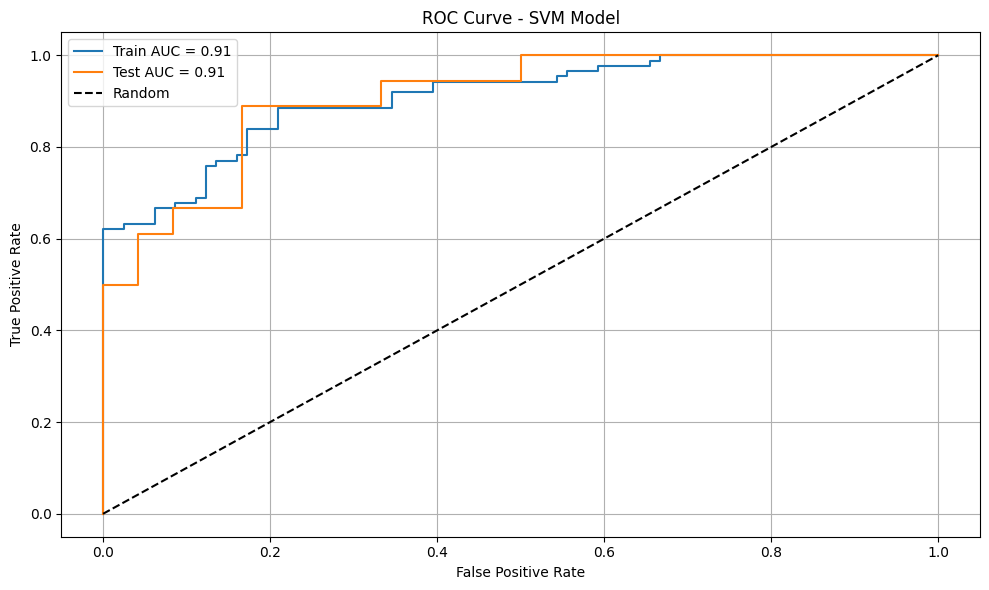

In [17]:
fpr_train, tpr_train, _ = roc_curve(y_train, train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr_train, tpr_train, label=f'Train AUC = {auc(fpr_train, tpr_train):.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUC = {auc(fpr_test, tpr_test):.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(results_path / "roc_curve_svm.png")
plt.show()


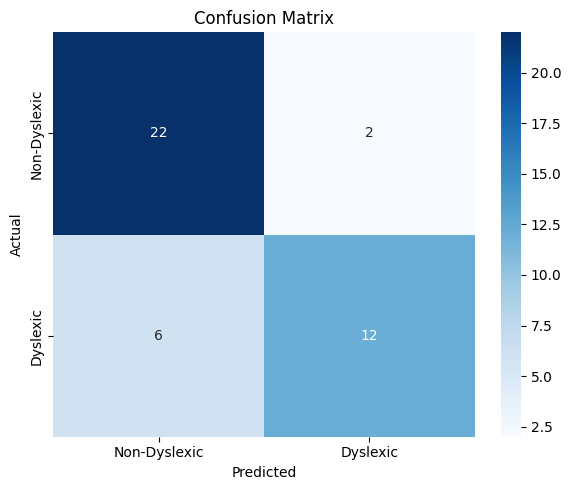

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Dyslexic', 'Dyslexic'], yticklabels=['Non-Dyslexic', 'Dyslexic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(results_path / "confusion_matrix_svm.png")
plt.show()

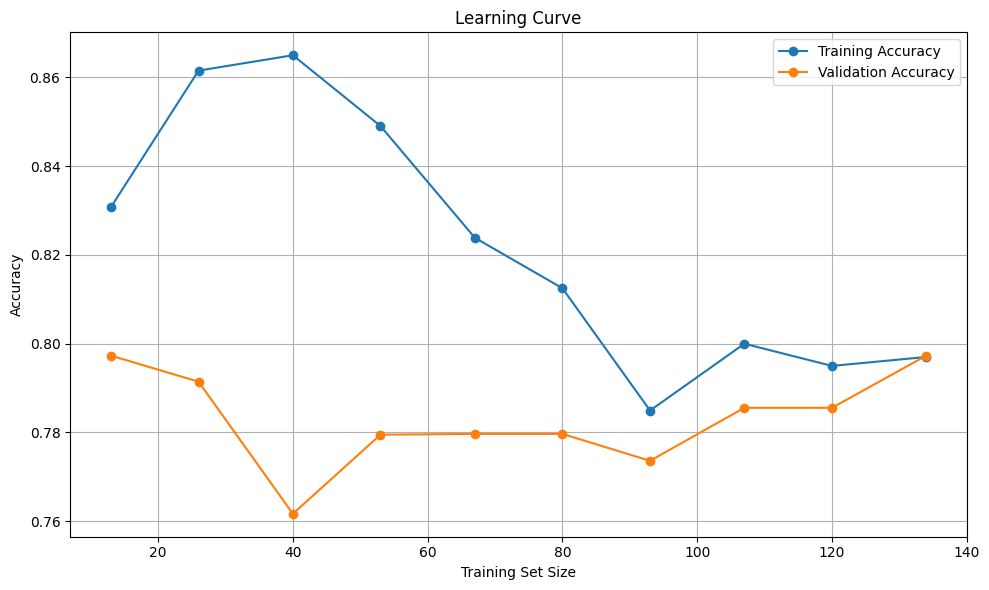

In [19]:
train_sizes, train_scores, val_scores = learning_curve(svm_model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Accuracy')
plt.title('Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(results_path / "learning_curve_svm.png")
plt.show()